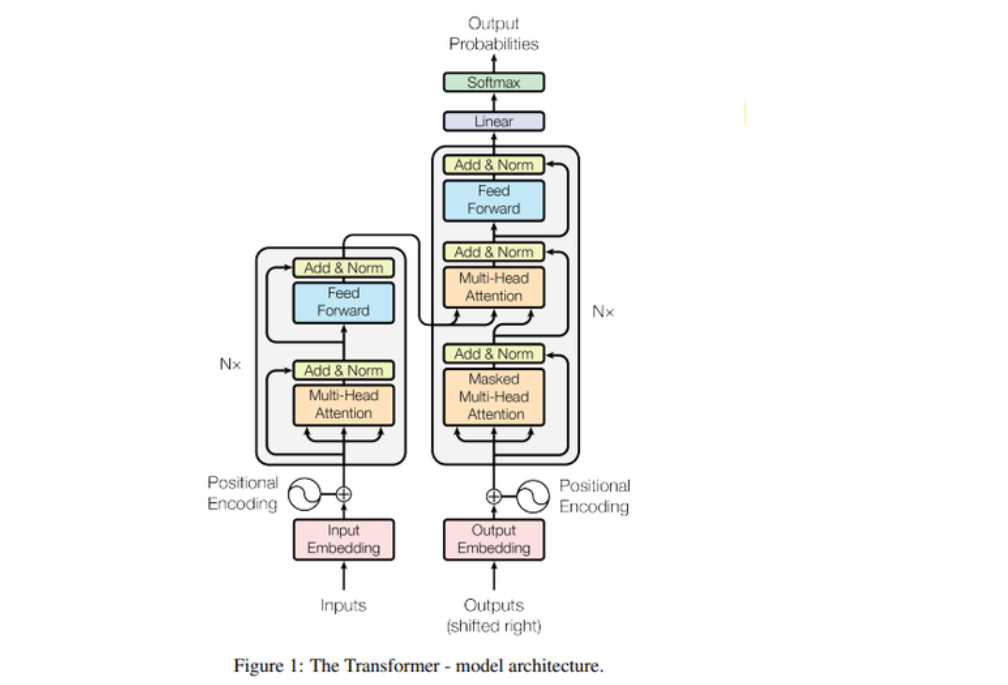

### Transformer Model from Scratch using TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, LayerNormalization
from tensorflow.keras.models import Model
import numpy as np


def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model)
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_logits += (mask * -1e9)
        attention_weights = tf.nn.softmax(scaled_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output


class PositionwiseFeedforward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super().__init__()
        self.dense1 = Dense(dff, activation='relu')
        self.dense2 = Dense(d_model)

    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedforward(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training=False, mask=None):
        attn_output = self.att(x, x, x, mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(
            maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)

        self.enc_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate)
                           for _ in range(num_layers)]

    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(
            maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)

        self.dec_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate)
                           for _ in range(num_layers)]

    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, training=training, mask=look_ahead_mask)

        return x, attention_weights


class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, maximum_position_encoding,
                 dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, maximum_position_encoding, dropout_rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, maximum_position_encoding, dropout_rate)
        self.final_layer = Dense(target_vocab_size)

    def call(self, inputs, training=False, look_ahead_mask=None, padding_mask=None):
        inp, tar = inputs

        enc_output = self.encoder(inp, training=training, mask=padding_mask)

        dec_output, _ = self.decoder(tar, enc_output, training=training,
                                     look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output


# Example hyperparameters
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = 8500
target_vocab_size = 8000
maximum_position_encoding = 10000
dropout_rate = 0.1

transformer = Transformer(
    num_layers,
    d_model,
    num_heads,
    dff,
    input_vocab_size,
    target_vocab_size,
    maximum_position_encoding,
    dropout_rate
)

inputs = tf.random.uniform((64, 50), dtype=tf.int64,
                           minval=0, maxval=input_vocab_size)
targets = tf.random.uniform(
    (64, 50), dtype=tf.int64, minval=0, maxval=target_vocab_size)

look_ahead_mask = None
padding_mask = None

output = transformer((inputs, targets), training=True,
                     look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

print(output.shape)

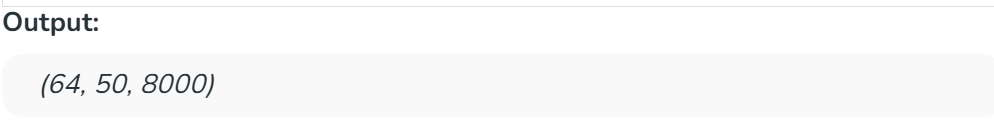